In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import cv2
import os
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
import os
import shutil
import random
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Prepare data

In [15]:
train_path = 'C:/Users/tomde/OneDrive/Documents/Deakin uni/Deakin-Data-Science/T1Y2/SIT225 - Data Capture Technologies/Week 9 - Research Use Case design/9.2HD/new_train_test/train/'
test_path =  'C:/Users/tomde/OneDrive/Documents/Deakin uni/Deakin-Data-Science/T1Y2/SIT225 - Data Capture Technologies/Week 9 - Research Use Case design/9.2HD/new_train_test/test/'

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=4,
                                   width_shift_range=0.15,
                                   height_shift_range=0.2,
                                   shear_range=0.3,
                                   fill_mode='nearest',
                                   validation_split=0.25)  # 25% for validation

# Training set (subset="training")
train_set = train_datagen.flow_from_directory(directory=train_path, 
                                              target_size=(64, 64),
                                              batch_size=128, 
                                              class_mode='categorical',
                                              color_mode='rgb',
                                              shuffle=True,
                                              subset="training")  # 75% for training

# Validation set (subset="validation")
validation_set = train_datagen.flow_from_directory(directory=train_path,
                                                   target_size=(64, 64),
                                                   batch_size=64,
                                                   class_mode='categorical',
                                                   color_mode='rgb',
                                                   subset="validation",  # 25% for validation
                                                   shuffle=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Test set
test_set = test_datagen.flow_from_directory(directory=test_path,
                                            target_size=(64, 64),
                                            batch_size=64,
                                            class_mode='categorical',
                                            color_mode='rgb',
                                            shuffle=True)

Found 6810 images belonging to 3 classes.
Found 2269 images belonging to 3 classes.
Found 4328 images belonging to 3 classes.


In [16]:
# Get the number of samples per class for training set
train_labels_count = train_set.classes
train_labels_len = {k: list(train_labels_count).count(v) for k, v in train_set.class_indices.items()}
print("Training set class distribution:", train_labels_len)

# Get the number of samples per class for validation set
val_labels_count = validation_set.classes
val_labels_len = {k: list(val_labels_count).count(v) for k, v in validation_set.class_indices.items()}
print("Validation set class distribution:", val_labels_len)

# Get the number of samples per class for test set
test_labels_count = test_set.classes
test_labels_len = {k: list(test_labels_count).count(v) for k, v in test_set.class_indices.items()}
print("Test set class distribution:", test_labels_len)

Training set class distribution: {'5': 2136, 'no': 2232, 'yes': 2442}
Validation set class distribution: {'5': 712, 'no': 743, 'yes': 814}
Test set class distribution: {'5': 1453, 'no': 1457, 'yes': 1418}


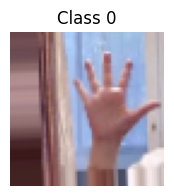

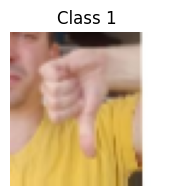

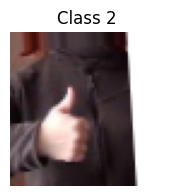

In [17]:
def view_one_image_per_class_in_order(data_generator, num_classes):
    # Dictionary to store the first image for each class
    class_images = {}
    
    # Loop through batches to find one image for each class
    for images_batch, labels_batch in data_generator:
        batch_size = images_batch.shape[0]
        for i in range(batch_size):
            # Get the class label of the current image
            class_label = np.argmax(labels_batch[i])
            
            # If we haven't stored an image for this class, save it
            if class_label not in class_images:
                class_images[class_label] = images_batch[i].squeeze()  # Store grayscale image

            # If we have collected images for all classes, stop
            if len(class_images) >= num_classes:
                break

        # Stop after collecting all classes
        if len(class_images) >= num_classes:
            break
    
    # Now, display one image for each class, in order
    for class_label in range(num_classes):
        plt.figure(figsize=(2, 2))
        plt.imshow(class_images[class_label], cmap='gray')  # Display the stored image
        plt.title(f'Class {class_label}')
        plt.axis('off')
        plt.show()

# Get the number of classes from the training set
num_classes = train_set.num_classes
view_one_image_per_class_in_order(train_set, num_classes)

In [18]:
# Check how many classes are in the dataset
num_classes = len(train_set.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 3


## Deep learning model

In [19]:
# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Make sure don't freeze any layers
for layer in base_model.layers:
    layer.trainable = True

# Add custom classification layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
output_layer = Dense(train_set.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [20]:
# Calculate class weights based on training data
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(train_set.classes),
                                                  y=train_set.classes)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 1.0627340823970037, 1: 1.0170250896057347, 2: 0.9295659295659295}


In [21]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_set,
                    epochs=200,
                    validation_data=validation_set,
                    callbacks=[early_stopping],
                    class_weight=class_weights_dict)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/200
54/54 [==============================] - 14s 196ms/step - loss: 0.4612 - accuracy: 0.8674 - val_loss: 14.6433 - val_accuracy: 0.3587
Epoch 2/200
54/54 [==============================] - 11s 197ms/step - loss: 0.0854 - accuracy: 0.9709 - val_loss: 1.7351 - val_accuracy: 0.3138
Epoch 3/200
54/54 [==============================] - 10s 192ms/step - loss: 0.0610 - accuracy: 0.9784 - val_loss: 1.1088 - val_accuracy: 0.3138
Epoch 4/200
54/54 [==============================] - 10s 190ms/step - loss: 0.0467 - accuracy: 0.9850 - val_loss: 1.1912 - val_accuracy: 0.3138
Epoch 5/200
54/54 [==============================] - 10s 191ms/step - loss: 0.0371 - accuracy: 0.9893 - val_loss: 1.3400 - val_accuracy: 0.3138
Epoch 6/200
54/54 [==============================] - 10s 191ms/step - loss: 0.0485 - accuracy: 0.9852 - val_loss: 1.7389 - val_accuracy: 0.3138
Epoch 7/200
54/54 [==============================] - 10s 193ms/step - loss: 0.0546 - accuracy: 0.9834 - val_loss: 1.0838 - val_accuracy

In [22]:
# Save the model after training
model.save('model11.h5')